# Credit Risk Analysis

### Library Installation and Import

In [ ]:
# Install the basic library required
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

# Install the library required for model building and evaluation
!pip install lightgbm
!pip install hyperopt
!pip install xgboost

In [ ]:
# Import the basic library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import the library for data preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Import the library for model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import lightgbm as lgbm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

### Import Data and Overview

In [ ]:
# Read the csv file using pandas to a dataframe.
df = pd.read_csv('credit_risk_dataset.csv')
# Review the first 5 data for overview
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
# Check the info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


## Section: Data Cleansing and Preprocessing
In this section, we are going to clean and preprocess our raw dataset before we can draw some insights from the cleaned data, as well as fit the processed data into our model candidates. We are going to do as follows:
1. Check and handle for any missing value, incorrectly formatted and duplicate data
2. Remove Outliers
3. Handle categorical variables by Encoding
4. Feature Scaling
5. Splitting Train and Test data for one-hot encoding and label encoding
**Person-in-charge:** Ho Tsz Hin, Cheong Euikyun

### 1. Check and handle any missing value

In [ ]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Based on the provided information, it appears that there are missing values in "person_emp_length" and "loan_int_rate" variable of the dataset. In order to ensure the integrity of our analysis, we have made the decision to remove these missing values. This approach has been adopted as we have enough observations in the dataset and the exclusion of missing data is not expected to significantly impact the outcomes of our analysis.

In [ ]:
# Remove the row with NaN entries
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28638 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28638 non-null  int64  
 1   person_income               28638 non-null  int64  
 2   person_home_ownership       28638 non-null  object 
 3   person_emp_length           28638 non-null  float64
 4   loan_intent                 28638 non-null  object 
 5   loan_grade                  28638 non-null  object 
 6   loan_amnt                   28638 non-null  int64  
 7   loan_int_rate               28638 non-null  float64
 8   loan_status                 28638 non-null  int64  
 9   loan_percent_income         28638 non-null  float64
 10  cb_person_default_on_file   28638 non-null  object 
 11  cb_person_cred_hist_length  28638 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.8+ MB


After the removal of missing values, there are total 28638 data left in our dataset.

### 2. Remove outliers

In [ ]:
# Get the Descriptive statistics
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,28638.000000,2.863800e+04,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000
mean,27.727216,6.664937e+04,4.788672,9656.493121,11.039867,0.216600,0.169488,5.793736
std,6.310441,6.235645e+04,4.154627,6329.683361,3.229372,0.411935,0.106393,4.038483
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.948000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.595600e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


From the above, we can see that the maximum age in the dataset is 144, which is abnormally high and we believe that they are outliers based on our domain knowledge and the fact from the guinness world records (the oldest person in this world is 122), so we decided to find out all the abnormally high person age and remove them.

In [ ]:
# Find out people with abnormally high age
df[df['person_age'] > 100]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N,3
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N,25


In [ ]:
# Remove the outliers
df = df.drop(df[df['person_age'] > 100].index)

In [ ]:
# Check the dimension of the dataset
df.shape

(28634, 12)

### 3. Handling categorical variables by Encoding

In [ ]:
# Split the data into numerical input and categorical input with output
cont_data = df.iloc[:,[0,1,3,6,7,9,11]]
cont_data.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,22,59000,123.0,35000,16.02,0.59,3
1,21,9600,5.0,1000,11.14,0.10,2
2,25,9600,1.0,5500,12.87,0.57,3
3,23,65500,4.0,35000,15.23,0.53,2
4,24,54400,8.0,35000,14.27,0.55,4


In [ ]:
cate_data = df.iloc[:,[2,4,5,8,10]]
cate_data.head()

,person_home_ownership,loan_intent,loan_grade,loan_status,cb_person_default_on_file
0,RENT,PERSONAL,D,1,Y
1,OWN,EDUCATION,B,0,N
2,MORTGAGE,MEDICAL,C,1,N
3,RENT,MEDICAL,C,1,N
4,RENT,MEDICAL,C,1,Y


For non-tree based Machine Learning Algorithms, the best way to go will be to use One-Hot Encoding.

One-Hot Encoding has the advantage that the result is binary rather than ordinal and that everything sits in an orthogonal vector space.
The disadvantage is that for high cardinality, the feature space can really blow up quickly and we start fighting with the curse of dimensionality. In these cases, we typically employ one-hot-encoding only since the new number of variables are reasonably suitable.

However, for logistic regression, applying one-hot encoding can cause the problem of multicollinearity, so we will apply label encoding for it later.

In [ ]:
# One-Hot Encoding for non-tree based MLA
cate_dataNoloanstatus=cate_data.drop(columns=['loan_status'])
cate_dataNoloanstatus=list(cate_dataNoloanstatus)
df_ohe=pd.get_dummies(df,columns=cate_dataNoloanstatus,drop_first=False)
df_ohe.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,22,59000,123.0,35000,16.02,1,0.59,3,0,0,...,0,0,0,0,1,0,0,0,0,1
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28634 entries, 0 to 32580
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      28634 non-null  int64  
 1   person_income                   28634 non-null  int64  
 2   person_emp_length               28634 non-null  float64
 3   loan_amnt                       28634 non-null  int64  
 4   loan_int_rate                   28634 non-null  float64
 5   loan_status                     28634 non-null  int64  
 6   loan_percent_income             28634 non-null  float64
 7   cb_person_cred_hist_length      28634 non-null  int64  
 8   person_home_ownership_MORTGAGE  28634 non-null  uint8  
 9   person_home_ownership_OTHER     28634 non-null  uint8  
 10  person_home_ownership_OWN       28634 non-null  uint8  
 11  person_home_ownership_RENT      28634 non-null  uint8  
 12  loan_intent_DEBTCONSOLIDATION   

For tree based Machine Learning Algorithms, the best way to go is with Label Encoding


There are algorithms like decision trees and random forests that can work with categorical variables just fine and LabelEncoder can be used to store values using less disk space.

In [ ]:
# Label Encoding for tree based MLA
df_le = df.apply(LabelEncoder().fit_transform)
df_le.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,2,1957,3,35,4,3,727,239,1,59,1,1
1,1,17,2,5,1,1,6,92,0,10,0,0
2,5,17,0,1,3,2,172,141,1,57,0,1
3,3,2229,3,4,3,2,727,217,1,53,0,0
4,4,1723,3,8,3,2,727,186,1,55,1,2


In [ ]:
df_le.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28634 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   person_age                  28634 non-null  int64
 1   person_income               28634 non-null  int64
 2   person_home_ownership       28634 non-null  int64
 3   person_emp_length           28634 non-null  int64
 4   loan_intent                 28634 non-null  int64
 5   loan_grade                  28634 non-null  int64
 6   loan_amnt                   28634 non-null  int64
 7   loan_int_rate               28634 non-null  int64
 8   loan_status                 28634 non-null  int64
 9   loan_percent_income         28634 non-null  int64
 10  cb_person_default_on_file   28634 non-null  int64
 11  cb_person_cred_hist_length  28634 non-null  int64
dtypes: int64(12)
memory usage: 2.8 MB


### 4. Feature Scaling

In [ ]:
# Split X and Y
y = df_ohe['loan_status'].values
X = df_ohe.drop(columns=['loan_status'])
# Min max normalization
normalize_scaler = MinMaxScaler()
minmax_df_ohe = normalize_scaler.fit_transform(X)
minmax_df_ohe = pd.DataFrame(minmax_df_ohe)
minmax_df_ohe.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.031250,0.027017,1.000000,1.000000,0.595506,0.710843,0.035714,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.015625,0.002751,0.040650,0.014493,0.321348,0.120482,0.000000,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.078125,0.002751,0.008130,0.144928,0.418539,0.686747,0.035714,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.046875,0.030209,0.032520,1.000000,0.551124,0.638554,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.062500,0.024757,0.065041,1.000000,0.497191,0.662651,0.071429,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Split X and Y
y = df_le['loan_status'].values
X = df_le.drop(columns=['loan_status'])
# Min max normalization
normalize_scaler = MinMaxScaler()
minmax_df_le = normalize_scaler.fit_transform(X)
minmax_df_le = pd.DataFrame(minmax_df_le)
minmax_df_le.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.037037,0.510566,1.000000,1.000000,0.8,0.500000,1.000000,0.688761,0.776316,1.0,0.035714
1,0.018519,0.004435,0.666667,0.142857,0.2,0.166667,0.008253,0.265130,0.131579,0.0,0.000000
2,0.092593,0.004435,0.000000,0.028571,0.6,0.333333,0.236589,0.406340,0.750000,0.0,0.035714
3,0.055556,0.581529,1.000000,0.114286,0.6,0.333333,1.000000,0.625360,0.697368,0.0,0.000000
4,0.074074,0.449517,1.000000,0.228571,0.6,0.333333,1.000000,0.536023,0.723684,1.0,0.071429


###5. Splitting Train and Test data for one-hot encoding and label encoding

For one-hot encoding

In [ ]:
# Create Train & Test Data
X_train1, X_test1, y_train1, y_test1 = train_test_split(minmax_df_ohe, df_ohe['loan_status'].values, test_size=0.2, stratify=df_ohe['loan_status'].values, random_state=0)

For label encoding (Without feature scaling)

In [ ]:
# Create Train & Test Data
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_le.drop(columns=['loan_status']), df_le['loan_status'].values, test_size=0.2, stratify=df_le['loan_status'].values, random_state=0)

## Section: Data Visualization
In this section, we are trying to see is there any relationship between the input in the data set. The following graphs will be generated:
1. Barplot for Age Distribution
2. Boxplot for Income and Loan amount
3. Pie Chart for Loan Status
4. Boxplot for Loan Interest Rate
5. Barplot for Categorical Variables
6. Correlation Heat Map for Continous Variables
7. Pie Chart for Percentage of Default on File
**Person-in-charge:** Cheong Euikyun, Lui Chak Sum

### 1. Barplot for Age Distribution

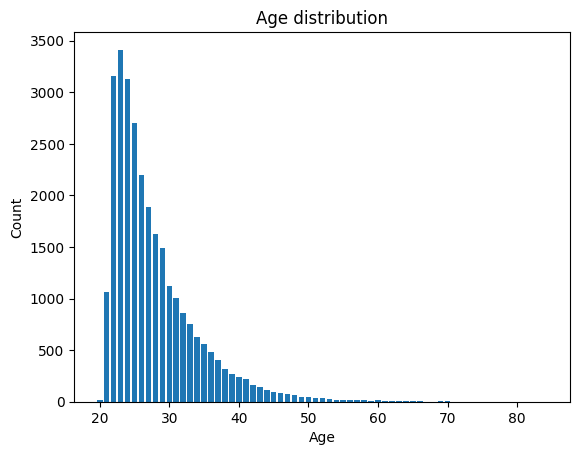

In [ ]:
# Count the number of Male and Female
value_counts = df['person_age'].value_counts()

# Create the barplot
plt.bar(value_counts.index, value_counts.values)

# Adding labels and title
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution')

# Show the plot
plt.show()


### 2. Boxplot for Income and Loan amount

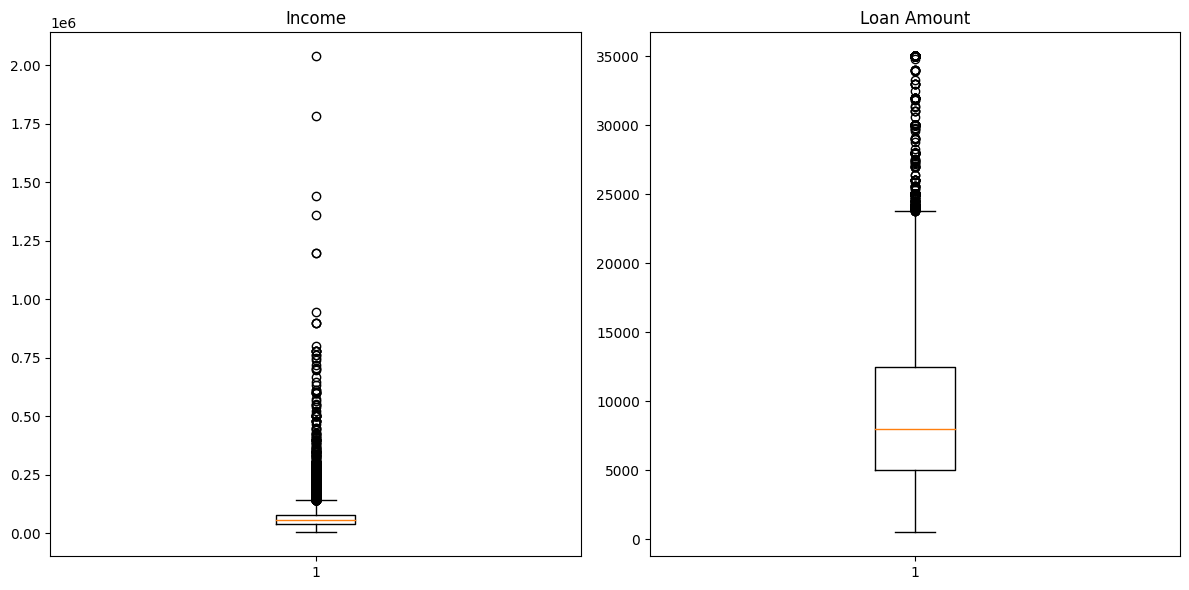

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the boxplot for income
plt.subplot(1, 2, 1)
plt.boxplot(df['person_income'])
plt.title('Income')
plt.xlabel('')

# Plot the boxplot for loan amount
plt.subplot(1, 2, 2)
plt.boxplot(df['loan_amnt'])
plt.title('Loan Amount')
plt.xlabel('')

# Show the plot
plt.tight_layout()
plt.show()

### 3. Pie Chart for Loan Status

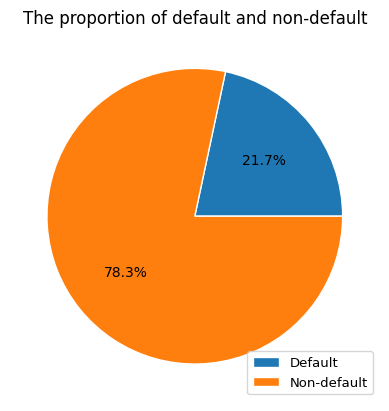

In [ ]:
# Variables for generating the graph
labels = ["Default", "Non default"]
value = [df["loan_status"].value_counts()[1], df["loan_status"].value_counts()[0]]

# Generate pie chart
fig, ax = plt.subplots()
ax.pie(value, autopct = '%1.1f%%', wedgeprops = {"linewidth": 1, "edgecolor": "white"})

# Adding legend
plt.legend(["Default", "Non-default"], fontsize=9.5, loc="lower right")

# Show the chart with title
ax.set_title("The proportion of default and non-default")
plt.show()

### 4. Boxplot for Loan Interest Rate

[Text(0.5, 1.0, 'Boxplot for loan interest rate')]

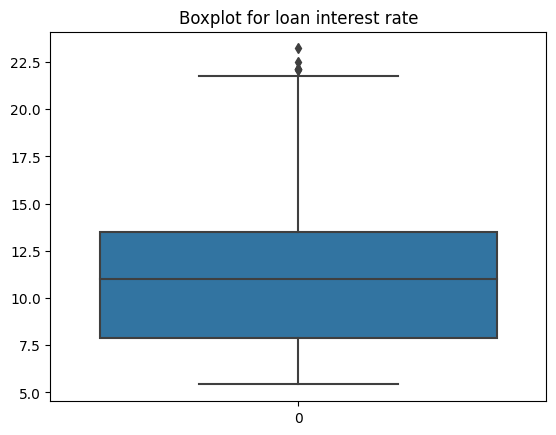

In [ ]:
# Build the boxplot
sns.boxplot(x=df['loan_int_rate']).set(title='Boxplot for loan interest rate')

### 5. Barplot for Categorical Variables

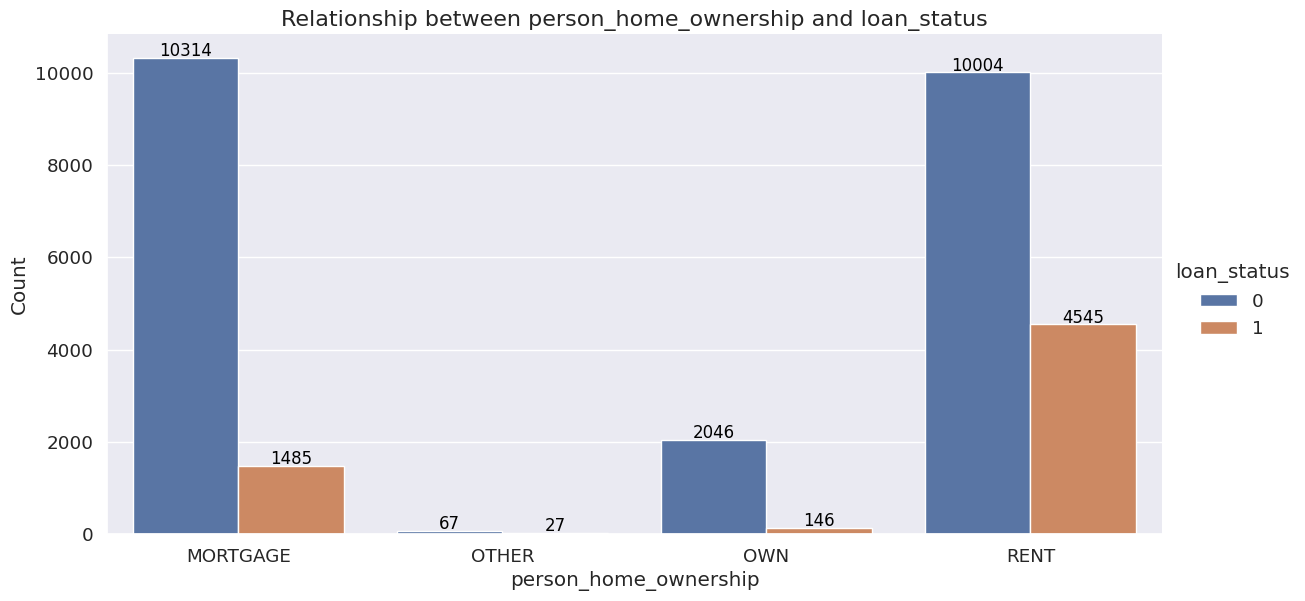

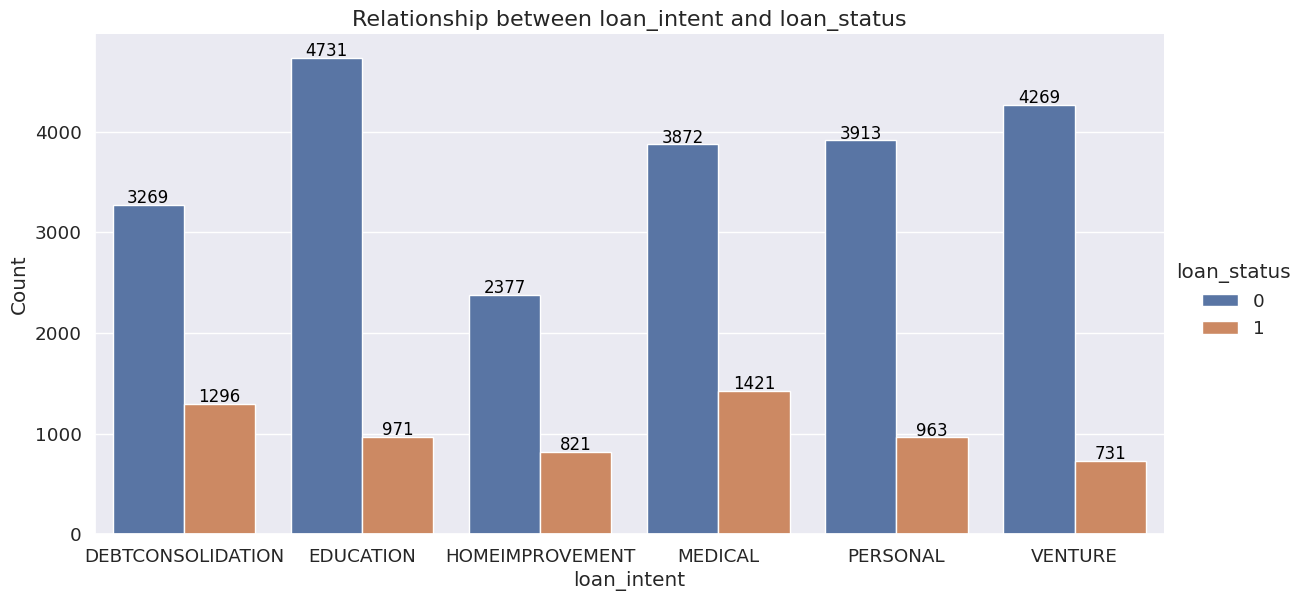

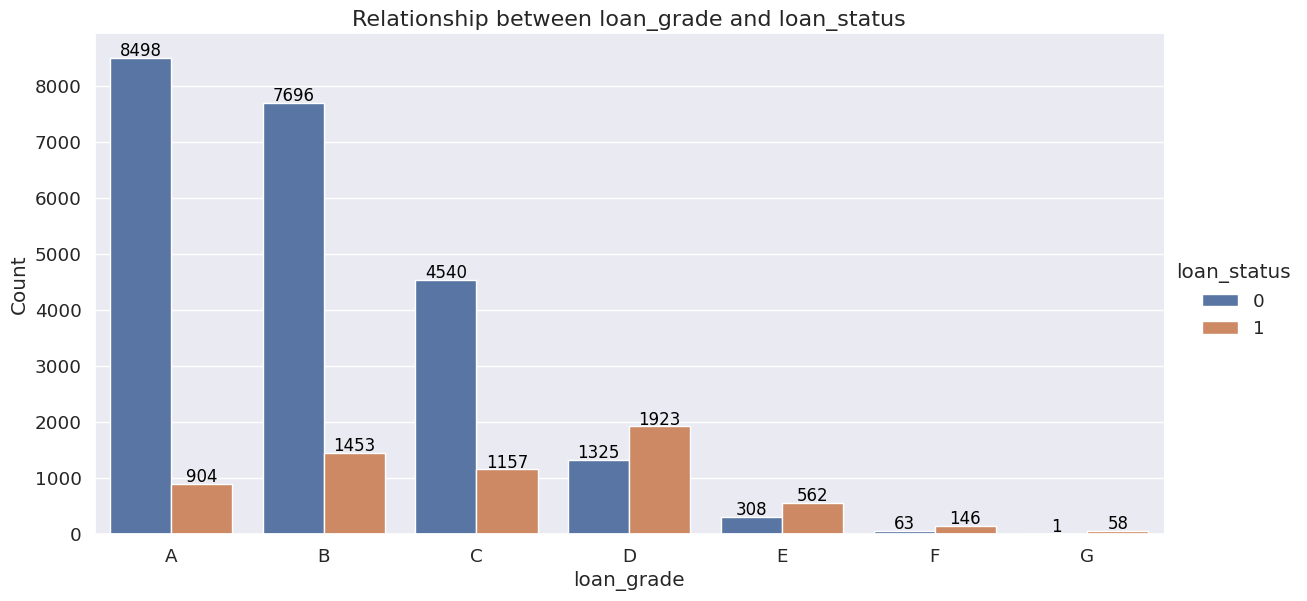

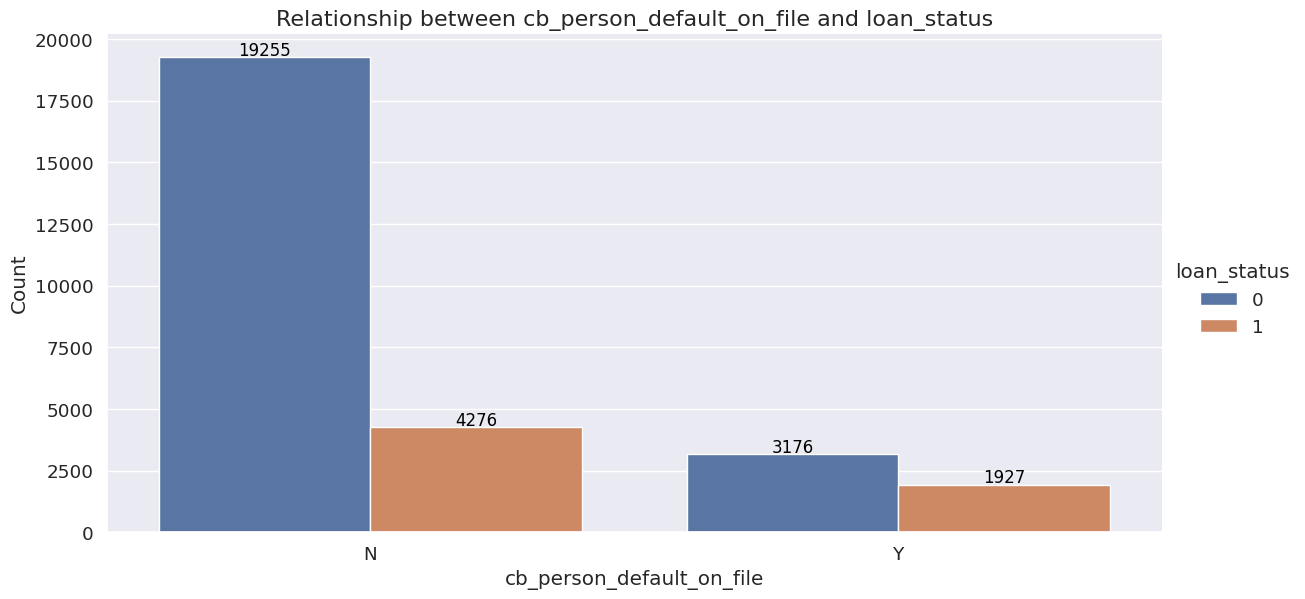

In [ ]:
# Define the list of categorical columns we want to visualize
categorical_columns = ['person_home_ownership',	'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Customize the font size
sns.set(font_scale=1.2)

# Define the legend labels
legend_labels = {
    '0': 'Non-default',
    '1': 'Default'
}

# Iterate over each categorical column
for col in categorical_columns:
    # Group by the current column and 'Churn' and calculate counts
    df_group = cate_data.groupby(col)['loan_status'].value_counts().rename('Count').reset_index()

    # Create a bar plot for the current column
    plot = sns.catplot(x=col, y='Count', hue='loan_status', kind='bar', data=df_group, height=6, aspect=12/6)

    # Add count labels on top of the bars
    for p in plot.ax.patches:
        plot.ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    # Set the title for the current plot
    plt.title(f'Relationship between {col} and loan_status', fontdict={'fontsize': 16})

    # Show the plot
    plt.show()

### 6. Correlation Heat Map for Continous Variables



Text(0.5, 1.0, 'Correlation Heatmap of Continuous Variables')

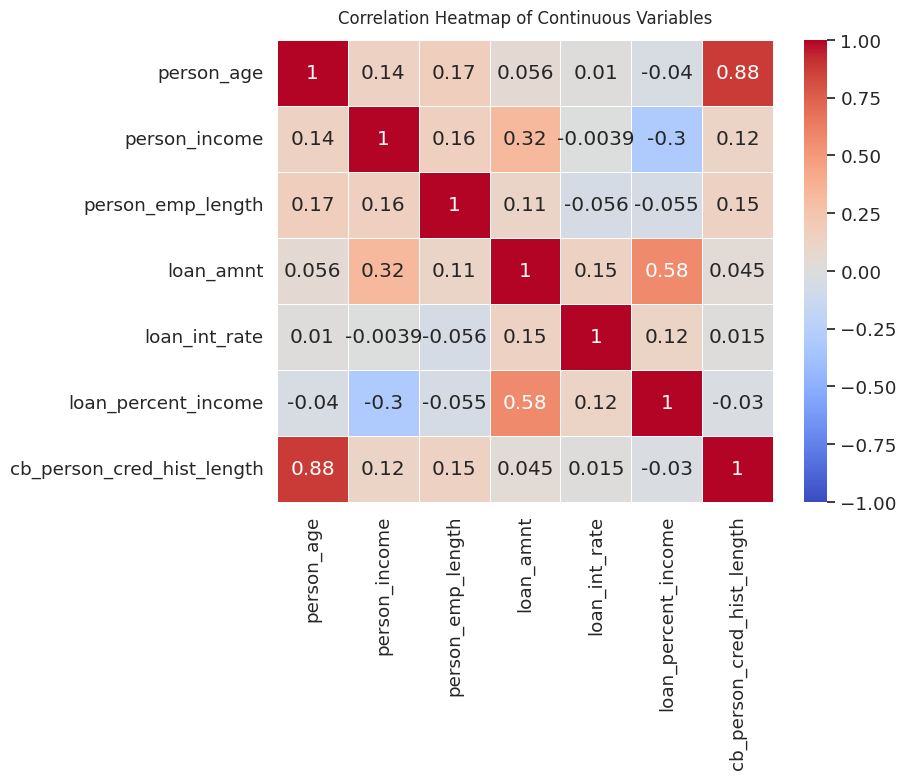

In [ ]:
# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cont_data.corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm", linewidths=0.5)
heatmap.set_title('Correlation Heatmap of Continuous Variables', fontdict={'fontsize':12}, pad=12)

### 7. Pie Chart for Percentage of Default on File

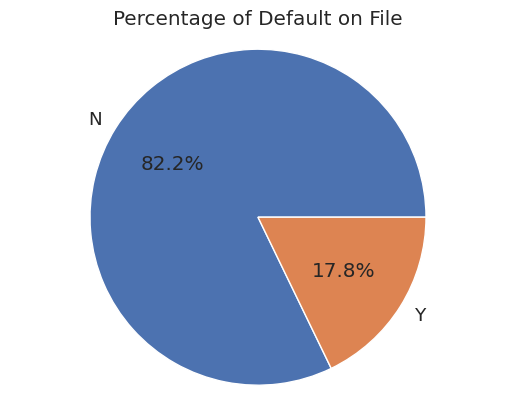

In [ ]:
# Calculate the value counts as percentages
value_counts = df['cb_person_default_on_file'].value_counts(normalize=True)

# Create the pie chart
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')

# Set aspect ratio to 'equal' to ensure a circular pie chart
plt.axis('equal')

# Add a title
plt.title("Percentage of Default on File")

# Display the chart
plt.show()

<Axes: ylabel='cb_person_default_on_file'>

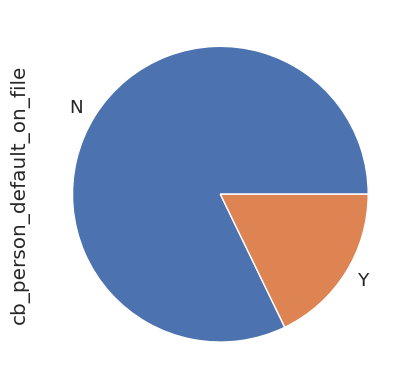

In [ ]:
df['cb_person_default_on_file'].value_counts(normalize=True).plot.pie()


## Section: Model Building
In this section, we are trying to train different models to predict the loan_status output. The following models will be generated:
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. Light Gradient Boosting Machine

E1. XGBoost and E2. K-NN Algorithm are also generated but due to spacing we will not include them in the report.

**Person-in-charge:** Li Shengwei(1), Chau Ka Yan(2), Wong Tuen Hong(3), Cheong Euikyun(4), Ho Tsz Hin(E1), Lui Chak Sum(E2)

In [ ]:
# Model Evaluation Function
def model_performance(y_test, y_pred) :
    #Show metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    print(f'Accuracy :{Accuracy}')
    print(f'Precision :{Precision}')
    print(f'Recall :{Recall}')
    print(f'F1_score :{F1_score}')

    return Accuracy, Precision, Recall, F1_score

### 1. Logistic Regression



Calculate VIF

In [ ]:
# Calculate Variance Inflation Factor
vif_scores = pd.DataFrame()
vif_scores["Attribute"] = df_le.drop(columns=['loan_status']).columns

# Calculating VIF for each feature
vif_scores["VIF Scores"] = [variance_inflation_factor(df_le.drop(columns=['loan_status']).values, i) for i in range(len(df_le.drop(columns=['loan_status']).columns))]

VIF=vif_scores
VIF

,Attribute,VIF Scores
0,person_age,11.103554
1,person_income,8.984164
2,person_home_ownership,2.476273
3,person_emp_length,2.583516
4,loan_intent,2.916777
5,loan_grade,20.747668
6,loan_amnt,16.321537
7,loan_int_rate,25.318963
8,loan_percent_income,11.416272
9,cb_person_default_on_file,1.717925


In [ ]:
## Drop 'loan_int_rate'
# Calculate Variance Inflation Factor
vif_scores = pd.DataFrame()
vif_scores["Attribute"] = df_le.drop(columns=['loan_status','loan_int_rate']).columns

# Calculating VIF for each feature
vif_scores["VIF Scores"] = [variance_inflation_factor(df_le.drop(columns=['loan_status','loan_int_rate']).values, i) for i in range(len(df_le.drop(columns=['loan_status','loan_int_rate']).columns))]

VIF=vif_scores
VIF

,Attribute,VIF Scores
0,person_age,11.103005
1,person_income,8.680334
2,person_home_ownership,2.441684
3,person_emp_length,2.578250
4,loan_intent,2.907566
5,loan_grade,2.982658
6,loan_amnt,16.145058
7,loan_percent_income,11.160921
8,cb_person_default_on_file,1.710918
9,cb_person_cred_hist_length,8.187328


In [ ]:
## Drop 'loan_int_rate', 'loan_amnt'
# Calculate Variance Inflation Factor
vif_scores = pd.DataFrame()
vif_scores["Attribute"] = df_le.drop(columns=['loan_status','loan_int_rate','loan_amnt']).columns

# Calculating VIF for each feature
vif_scores["VIF Scores"] = [variance_inflation_factor(df_le.drop(columns=['loan_status','loan_int_rate','loan_amnt']).values, i) for i in range(len(df_le.drop(columns=['loan_status','loan_int_rate','loan_amnt']).columns))]

VIF=vif_scores
VIF

,Attribute,VIF Scores
0,person_age,11.027030
1,person_income,3.254109
2,person_home_ownership,2.245125
3,person_emp_length,2.535391
4,loan_intent,2.796733
5,loan_grade,2.981244
6,loan_percent_income,2.979031
7,cb_person_default_on_file,1.710269
8,cb_person_cred_hist_length,8.175830


In [ ]:
## Drop 'loan_int_rate', 'loan_amnt', 'person_age'
# Calculate Variance Inflation Factor
vif_scores = pd.DataFrame()
vif_scores["Attribute"] = df_le.drop(columns=['loan_status','loan_int_rate','loan_amnt','person_age']).columns

# Calculating VIF for each feature
vif_scores["VIF Scores"] = [variance_inflation_factor(df_le.drop(columns=['loan_status','loan_int_rate','loan_amnt','person_age']).values, i) for i in range(len(df_le.drop(columns=['loan_status','loan_int_rate','loan_amnt','person_age']).columns))]

VIF=vif_scores
VIF

,Attribute,VIF Scores
0,person_income,3.124955
1,person_home_ownership,2.226121
2,person_emp_length,2.499063
3,loan_intent,2.782956
4,loan_grade,2.979433
5,loan_percent_income,2.948955
6,cb_person_default_on_file,1.710243
7,cb_person_cred_hist_length,1.902376


In [ ]:
# Select the columns in minmax_df_le
minmax_df_le_logreg = minmax_df_le.iloc[:,[1,2,3,4,5,8,9,10]]

In [ ]:
# Create Train & Test Data
X_train3, X_test3, y_train3, y_test3 = train_test_split(minmax_df_le_logreg, df_le['loan_status'].values, test_size=0.2, stratify=df_le['loan_status'].values, random_state=0)

Without hyperparameter tuning

In [ ]:
# Create the solver
logistic = LogisticRegression(solver='liblinear', random_state=0)

# Fitting the model
logistic.fit(X_train3, y_train3)

# Predict the loan_status
logistic_pred = logistic.predict(X_test3)

# Evaluate the model
log_Accuracy, log_Precision, log_Recall, log_F1_score = model_performance(y_test3, logistic_pred)

Accuracy :0.8433734939759037
Precision :0.7067307692307693
Recall :0.47381144238517325
F1_score :0.5672937771345876


With hyperparameter tuning

In [ ]:
# Set the parameters for grid search
param_grid_log = {'C': [0.1, 1, 10, 12, 15],'penalty': ['l1', 'l2']}

# Create a based model
Logistic_model= LogisticRegression(solver='liblinear',random_state=0)

# Instantiate the grid search model
logistic_gs = GridSearchCV(
        estimator = Logistic_model,
        param_grid = param_grid_log,
        n_jobs = -1,
        cv=3
)
# Fit the grid search to the data
logistic_gs.fit(X_train3, y_train3)

# Find the best hyperparameters and corresponding model
best_params_logistic = logistic_gs.best_params_
best_model_logistic = logistic_gs.best_estimator_

# Print the best hyperparameters
print("Best parameters for logistic regression", best_params_logistic)

# Predict the loan_status
logistic_gs_pred = best_model_logistic.predict(X_test3)

# Evalute the model
log_gs_Accuracy, log_gs_Precision, log_gs_Recall, log_gs_F1_score = model_performance(y_test3, logistic_gs_pred)

Best parameters for logistic regression {'C': 1, 'penalty': 'l1'}
Accuracy :0.8431988824864676
Precision :0.7053892215568862
Recall :0.47461724415793716
F1_score :0.567437379576108


<Axes: ylabel='Feature'>

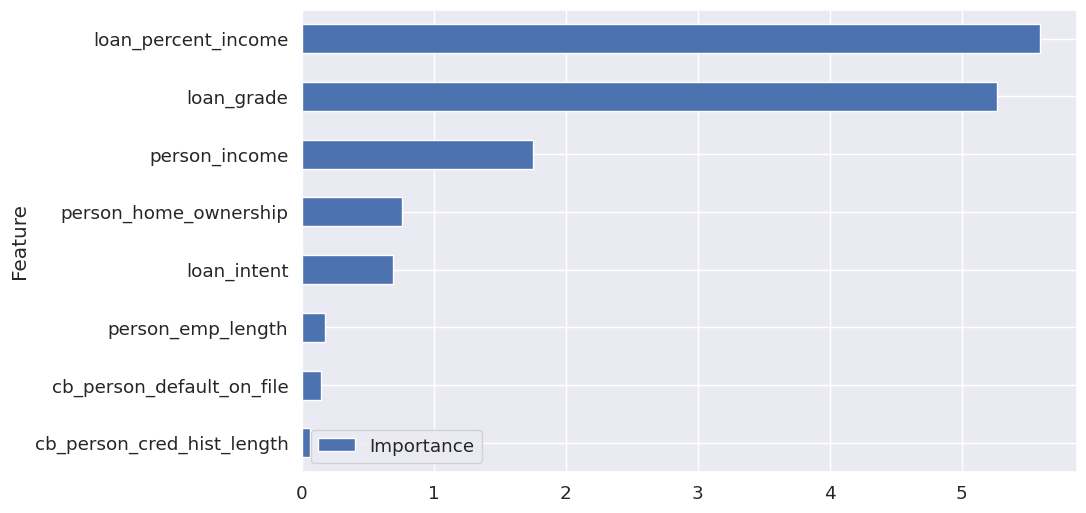

In [ ]:
# Feature importance calculation
coefficients = logistic.coef_[0]

feature_importance = pd.DataFrame({'Feature': df_le.drop(columns=['loan_status','loan_int_rate','loan_amnt','person_age']).columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))


In [ ]:
# Print the feature scores
feature_scores = feature_importance.sort_values(by=feature_importance.columns[1], ascending=False)
feature_scores

,Feature,Importance
5,loan_percent_income,5.591484
4,loan_grade,5.269133
0,person_income,1.754716
1,person_home_ownership,0.762297
3,loan_intent,0.692671
2,person_emp_length,0.174834
6,cb_person_default_on_file,0.143984
7,cb_person_cred_hist_length,0.064370


### 2. Decision Tree

Without hyperparameter tuning

In [ ]:
# Build a Decision Tree Classifier
DecisionTree = DecisionTreeClassifier(random_state=0)

# Fitting the model
DecisionTree.fit(X_train2, y_train2)

# Predict the loan_status
DecisionTree_pred = DecisionTree.predict(X_test2)

# Evaluate the model
dt_Accuracy, dt_Precision, dt_Recall, dt_F1_score = model_performance(y_test2, DecisionTree_pred)

Accuracy :0.8847564169722367
Precision :0.7260700389105058
Recall :0.7518130539887188
F1_score :0.7387173396674583


With hyperparameter tuning

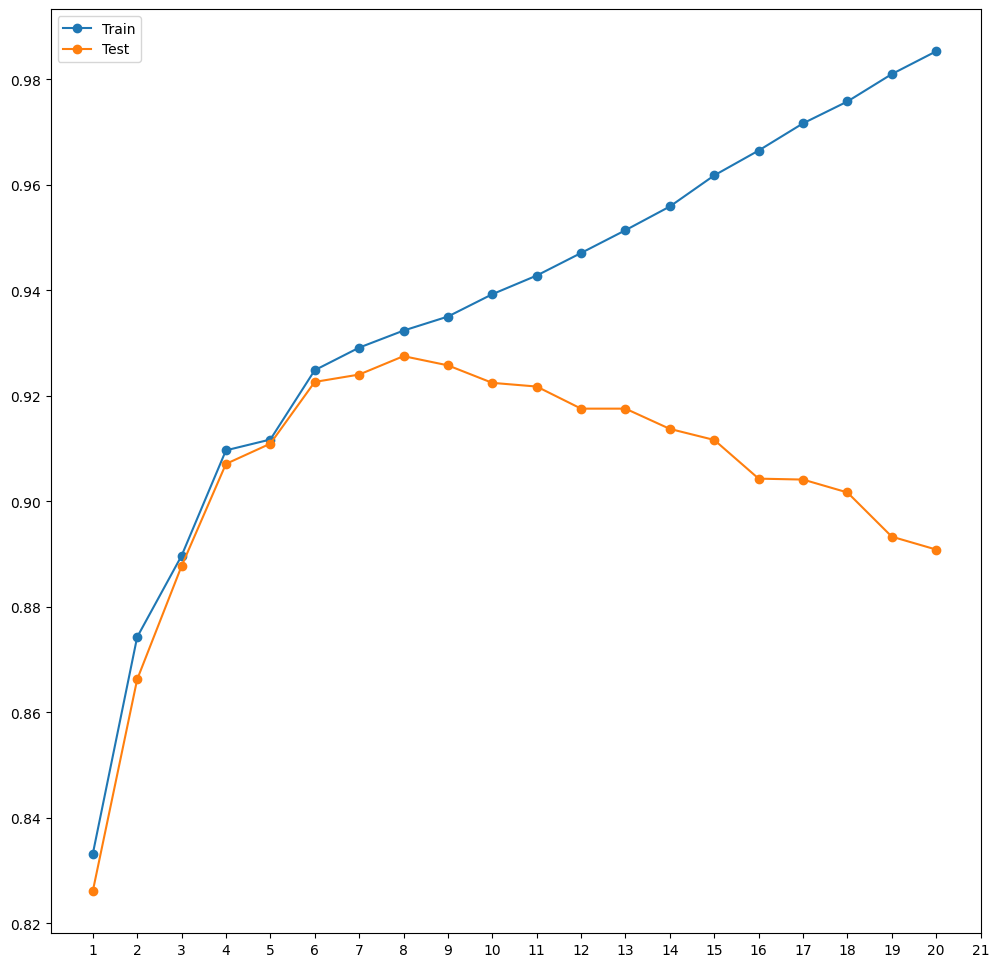

In [ ]:
values = [i for i in range(1, 21)]
train_scores, test_scores = list(), list()

# evaluate a decision tree for each depth
for i in values:
    DecisionTree_tune = DecisionTreeClassifier(max_depth=i, random_state=0)
    DecisionTree_tune = DecisionTree_tune.fit(X_train2, y_train2)

    # evaluate on the train dataset
    train_ypred = DecisionTree_tune.predict(X_train2)
    train_acc = metrics.accuracy_score(y_train2, train_ypred)
    train_scores.append(train_acc)

    # evaluate on the test dataset
    test_ypred = DecisionTree_tune.predict(X_test2)
    test_acc = metrics.accuracy_score(y_test2, test_ypred)
    test_scores.append(test_acc)

# plot of train and test scores vs tree depth
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(values, train_scores, '-o', label='Train')
ax.plot(values, test_scores, '-o', label='Test')
ax.set_xticks([x for x in range(1,22)])
ax.legend()
plt.show()

From the line chart above, a max_depth = 8 gives the best score for both the test and training data set.

In [ ]:
# Build a Decision Tree Classifier
DecisionTree_tune = DecisionTreeClassifier(random_state=0, max_depth = 8)

# Fitting the model
DecisionTree_tune = DecisionTree_tune.fit(X_train2,y_train2)

# Predict the Churn
DecisionTree_tune_pred = DecisionTree_tune.predict(X_test2)

# Evaluate the model
dt_tune_Accuracy, dt_tune_Precision, dt_tune_Recall, dt_tune_F1_score = model_performance(y_test2, DecisionTree_tune_pred)

Accuracy :0.927536231884058
Precision :0.9682539682539683
Recall :0.6881547139403706
F1_score :0.8045219029674987


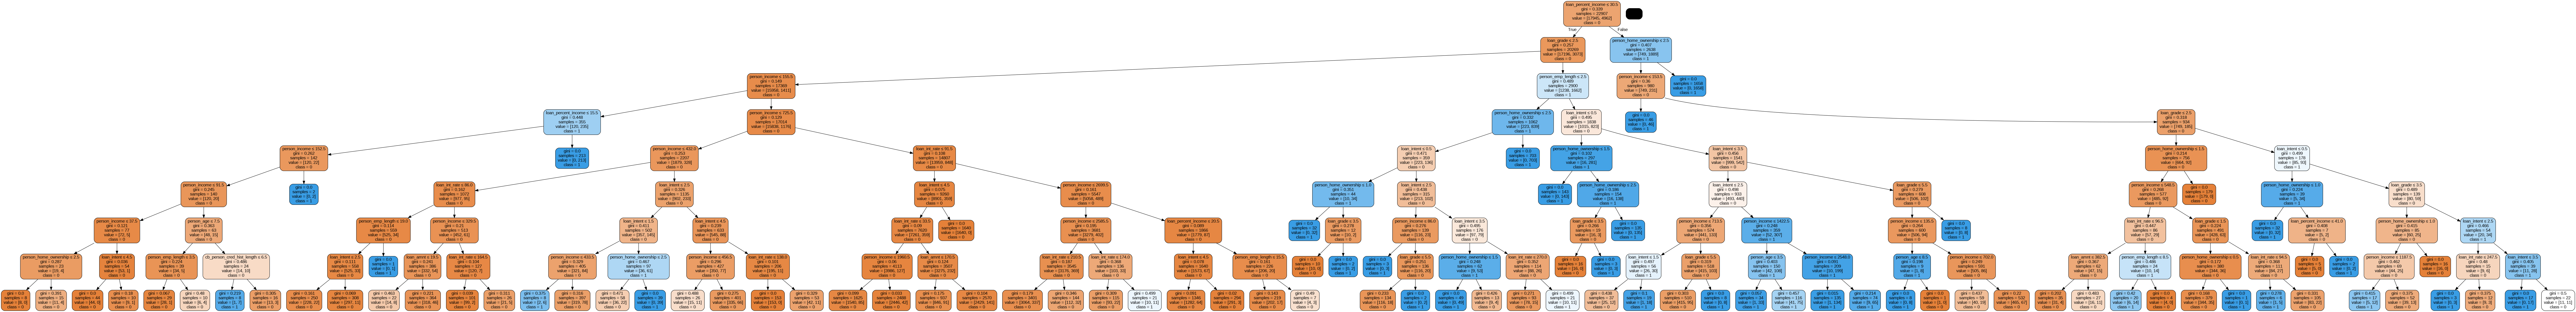

In [ ]:
# Decision tree plot
dot_data = StringIO()
export_graphviz(DecisionTree_tune, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train2.columns ,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('DecisionTree.png')
Image(graph.create_png())

<Axes: >

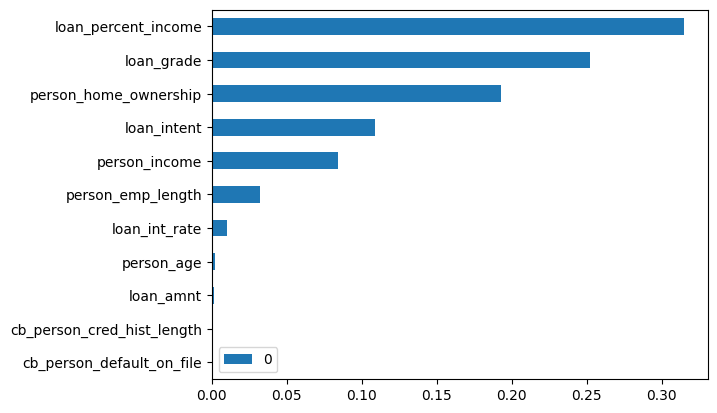

In [ ]:
# Feature importance calculation
fi_dt = pd.DataFrame(DecisionTree_tune.feature_importances_)
fi_dt.index = DecisionTree_tune.feature_names_in_
fi_dt = fi_dt.sort_values(by=0)
fi_dt.plot.barh()

In [ ]:
# Print the feature scores
feature_scores = pd.Series(DecisionTree_tune.feature_importances_, index=X_train2.columns).sort_values(ascending=False)
feature_scores

### 3. Random Forest

Without hyperparameter tuning

In [ ]:
# Build the classifier
randomForest = RandomForestClassifier(random_state=42)

# Fitting the Model
randomForest.fit(X_train2, y_train2)

# Predict the loan_status
rf_pred = randomForest.predict(X_test2)

# Evaluate the model
rf_Accuracy, rf_Precision, rf_Recall, rf_F1_score = model_performance(y_test2, rf_pred)

Accuracy :0.9280600663523659
Precision :0.958011049723757
Recall :0.6986301369863014
F1_score :0.8080149114631874


With hyperparameter tuning

In [ ]:
# Set the parameters for grid search
param_grid_rf = {'max_depth': [20, 40, 60, 80],
          'n_estimators': [100, 200, 300]}

# Create a based model
rf = RandomForestClassifier(random_state = 42)

# Instantiate the grid search model
rf_gs = GridSearchCV(estimator = rf,
            param_grid = param_grid_rf,
            cv = 3,
            n_jobs = -1,
            verbose = 2
)

# Fit the grid search to the data
rf_gs.fit(X_train2, y_train2)

# Find the best hyperparameters
best_params_rf = rf_gs.best_params_

# Print the best hyperparameters
print("Best parameters for random forest", best_params_rf)

# Generate predictions with the best model
best_model_rf = RandomForestClassifier(
                  max_depth = best_params_rf['max_depth'],
                  n_estimators = best_params_rf['n_estimators']

                  )

# Fitting the Model
best_model_rf.fit(X_train2, y_train2)

# Predict the loan_status
rf_gs_pred = best_model_rf.predict(X_test2)

# Evalute the model
rf_gs_Accuracy, rf_gs_Precision, rf_gs_Recall, rf_gs_F1_score = model_performance(y_test2, rf_gs_pred)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for random forest {'max_depth': 60, 'n_estimators': 300}
Accuracy :0.92875851231011
Precision :0.9551912568306011
Recall :0.7042707493956487
F1_score :0.8107606679035251


<Axes: >

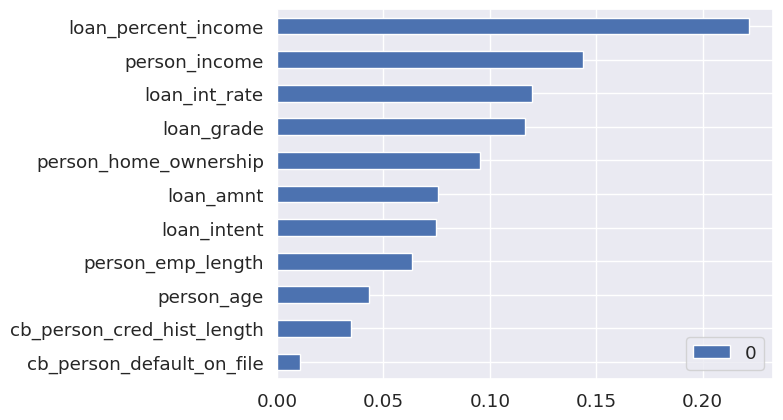

In [ ]:
# Feature importance calculation
fi_rf = pd.DataFrame(best_model_rf.feature_importances_)
fi_rf.index = best_model_rf.feature_names_in_
fi_rf = fi_rf.sort_values(by=0)
fi_rf.head(15).plot.barh()

In [ ]:
# Print the feature scores
feature_scores = pd.Series(best_model_rf.feature_importances_, index=X_train2.columns).sort_values(ascending=False)
feature_scores

loan_percent_income           0.221943
person_income                 0.143774
loan_int_rate                 0.119855
loan_grade                    0.116566
person_home_ownership         0.095509
loan_amnt                     0.075728
loan_intent                   0.074586
person_emp_length             0.063232
person_age                    0.043424
cb_person_cred_hist_length    0.034611
cb_person_default_on_file     0.010774
dtype: float64

### 4. LGBM (Light Gradient Boosting Machine)

Without hyperparameter tuning

In [ ]:
# Build the classifier
lgbm_clf = lgbm.LGBMClassifier(n_estimator=400,random_state = 42)

# Fitting the Model
lgbm_clf.fit(X_train2, y_train2)

# Predict the loan_status
simple_lgbm_pred = lgbm_clf.predict(X_test2)

# Evaluate the model
simple_lgbm_Accuracy, simple_lgbm_Precision, simple_lgbm_Recall, simple_lgbm_F1_score = model_performance(y_test2, simple_lgbm_pred)

[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Info] Number of positive: 4962, number of negative: 17945
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 915
[LightGBM] [Info] Number of data points in the train set: 22907, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216615 -> initscore=-1.285503
[LightGBM] [Info] Start training from score -1.285503
[LightGBM] [Warning] Unknown parameter: n_estimator
Accuracy :0.9353937489086782
Precision :0.9738846572361263
Recall :0.7211925866236906
F1_score :0.8287037037037038


With hyperparameter tuning

In [ ]:
# Set the parameters for grid search
param_grid_lgbm = {'n_estimators': [100, 200, 300],
           'learning_rate': [0.05, 0.1, 0.2],
           'max_depth': [6, 8, 10],
           'num_leaves': [31, 63, 127],
           'min_child_samples': [20, 30, 40],
}

# Create a based model
lgbm_gs_clf = lgbm.LGBMClassifier(random_state=42)

# Instantiate the grid search model
lgbm_gs = GridSearchCV(estimator = lgbm_gs_clf,
             param_grid = param_grid_lgbm,
             cv=3,
             scoring='accuracy',
             n_jobs=-1
)

# Fit the grid search to the data
lgbm_gs.fit(X_train2, y_train2)

# Find the best hyperparameters and corresponding model
best_params_lgbm = lgbm_gs.best_params_
best_model_lgbm = lgbm_gs.best_estimator_

# Print the best hyperparameters
print("Best parameters for lgbm", best_params_lgbm)

# Predict the loan_status
lgbm_gs_pred = best_model_lgbm.predict(X_test2)

# Evalute the model
lgbm_gs_Accuracy, lgbm_gs_Precision, lgbm_gs_Recall, lgbm_gs_F1_score = model_performance(y_test2, lgbm_gs_pred)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4962, number of negative: 17945
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 915
[LightGBM] [Info] Number of data points in the train set: 22907, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216615 -> initscore=-1.285503
[LightGBM] [Info] Start training from score -1.285503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

<Axes: >

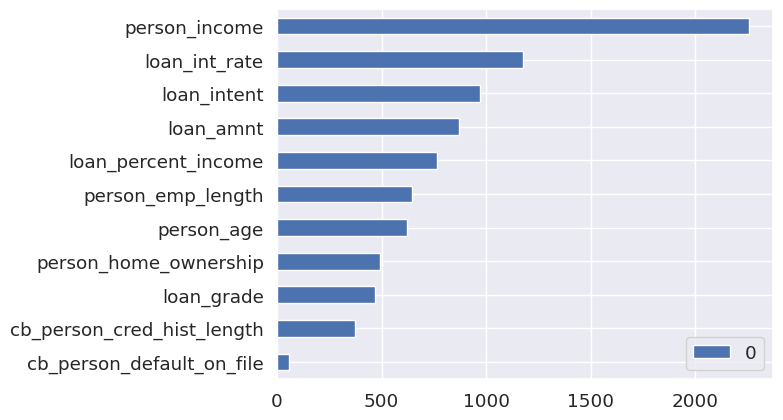

In [ ]:
# Feature importance calculation
fi_lgbm = pd.DataFrame(best_model_lgbm.feature_importances_)
fi_lgbm.index = DecisionTree_tune.feature_names_in_
fi_lgbm = fi_lgbm.sort_values(by=0)
fi_lgbm.head(15).plot.barh()

In [ ]:
# Print the feature scores
feature_scores = pd.Series(best_model_lgbm.feature_importances_, index=X_train2.columns).sort_values(ascending=False)
feature_scores

person_income                 2259
loan_int_rate                 1178
loan_intent                    969
loan_amnt                      869
loan_percent_income            763
person_emp_length              644
person_age                     619
person_home_ownership          493
loan_grade                     467
cb_person_cred_hist_length     375
cb_person_default_on_file       58
dtype: int32

In [ ]:
## deleting cb_person_default_on_file
# Set the parameters for grid search
param_grid_lgbm = {'n_estimators': [100, 200, 300],
           'learning_rate': [0.05, 0.1, 0.2],
           'max_depth': [6, 8, 10],
           'num_leaves': [31, 63, 127],
           'min_child_samples': [20, 30, 40],
}

# Create a based model
lgbm_gs_clf = lgbm.LGBMClassifier(random_state=42)

# Instantiate the grid search model
lgbm_gs = GridSearchCV(estimator = lgbm_gs_clf,
             param_grid = param_grid_lgbm,
             cv=3,
             scoring='accuracy',
             n_jobs=-1
)

# Fit the grid search to the data
lgbm_gs.fit(X_train2.drop(columns=['cb_person_default_on_file']), y_train2)

# Find the best hyperparameters and corresponding model
best_params_lgbm = lgbm_gs.best_params_
best_model_lgbm = lgbm_gs.best_estimator_

# Print the best hyperparameters
print("Best parameters for lgbm", best_params_lgbm)

# Predict the loan_status
lgbm_gs_pred = best_model_lgbm.predict(X_test2.drop(columns=['cb_person_default_on_file']))

# Evalute the model
lgbm_gs_Accuracy, lgbm_gs_Precision, lgbm_gs_Recall, lgbm_gs_F1_score = model_performance(y_test2, lgbm_gs_pred)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4962, number of negative: 17945
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 913
[LightGBM] [Info] Number of data points in the train set: 22907, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216615 -> initscore=-1.285503
[LightGBM] [Info] Start training from score -1.285503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

### E1. XG Boost (Excluded in report)

Without hyperparameter tuning

In [ ]:
# Build the classifier
XGB = XGBClassifier(random_state=0)

# Fitting the Model
XGB.fit(X_train2, y_train2)

# Predict the loan_status
XGB_pred = XGB.predict(X_test2)

# Evaluate the model
XGB_Accuracy, XGB_Precision, XGB_Recall, XGB_F1_score = model_performance(y_test2, XGB_pred)

Accuracy :0.9332984110354461
Precision :0.9478623566214807
Recall :0.7324738114423852
F1_score :0.8263636363636363


With hyperparameter tuning

In [ ]:
param_grid_XGB = {
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300, 500, 1000],
    'gamma': [0, 0.1, 0.2],
    'subsample': [1.0],
    'colsample_bytree': [1.0]
}

# Create an XGBoost classifier
xgb = XGBClassifier(random_state=0)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid_XGB,
                           cv=3,
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train2, y_train2)

# Get the best hyperparameters and corresponding model
best_params_XGB = grid_search.best_params_
best_model_XGB = grid_search.best_estimator_

# Print the best hyperparameters
print("Best parameters for XGBoost:", best_params_XGB)

Best parameters for XGBoost: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}


In [ ]:
# Build the classifier
best_model_XGB = XGBClassifier(colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth= 6, n_estimators =200, subsample = 1.0, random_state=0)

# Fitting the Model
best_model_XGB.fit(X_train2, y_train2)

# Predict the loan_status
XGB_gs_pred = best_model_XGB.predict(X_test2)

# Evaluate the model
XGB_gs_Accuracy, XGB_gs_Precision, XGB_gs_Recall, XGB_gs_F1_score = model_performance(y_test2, XGB_gs_pred)

Accuracy :0.9355683603981142
Precision :0.9658119658119658
Recall :0.7284448025785657
F1_score :0.8305006890215895


<Axes: >

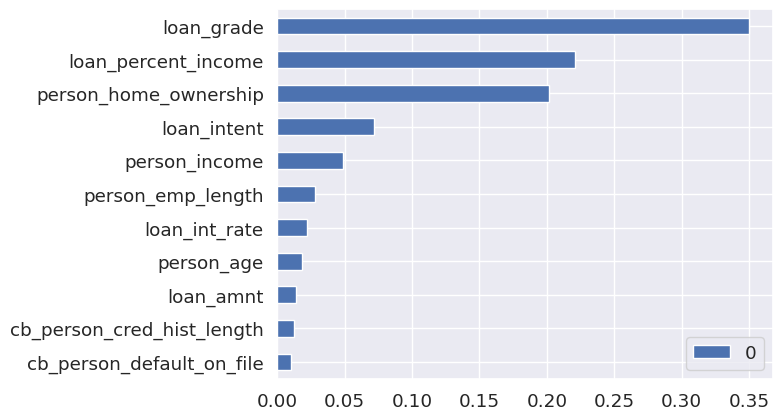

In [ ]:
# Feature importance calculation
fi_XGB = pd.DataFrame(best_model_XGB.feature_importances_)
fi_XGB.index = best_model_XGB.feature_names_in_
fi_XGB = fi_XGB.sort_values(by=0)
fi_XGB.head(15).plot.barh()

### E2. K-NN Algorithm (Excluded in report)

Without hyperparameter tuning

In [ ]:
# Build the classifier
KNN = KNeighborsClassifier()

# Fitting the Model
KNN.fit(X_train1, y_train1)

# Predict the loan_status
KNN_pred = KNN.predict(X_test1)

# Evaluate the model
KNN_Accuracy, KNN_Precision, KNN_Recall, KNN_F1_score = model_performance(y_test1, KNN_pred)

Accuracy :0.889296315697573
Precision :0.8361018826135105
Recall :0.6083803384367445
F1_score :0.7042910447761194


With hyperparameter tuning

In [ ]:
# Set the parameters for grid search
param_grid_KNN = {
    'n_neighbors': range(5, 50, 5),
    'p': [1,2],
    'weights': ['uniform', 'distance']
}

# Create a based model
KNN_gs = KNeighborsClassifier()

# Instantiate the grid search model
KNN_gs = GridSearchCV(estimator = KNN_gs,
            param_grid = param_grid_KNN,
            cv = 3,
            n_jobs = 5,
)

# Fit the grid search to the data
KNN_gs.fit(X_train1, y_train1)

# Find the best hyperparameters and corresponding model
best_params_KNN = KNN_gs.best_params_
best_model_KNN = KNN_gs.best_estimator_

# Print the best hyperparameters
print("Best parameters for KNN", best_params_KNN)

# Predict the loan_status
KNN_gs_pred = best_model_KNN.predict(X_test1)

# Evalute the model
KNN_gs_Accuracy, KNN_gs_Precision, KNN_gs_Recall, KNN_gs_F1_score = model_performance(y_test1, KNN_gs_pred)

Best parameters for KNN {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Accuracy :0.894185437401781
Precision :0.869615832363213
Recall :0.6019339242546333
F1_score :0.7114285714285714


## Section: Model Evaluation
In this section, we will summarize the model performance in the previous section and plot the AUC-ROC Curve.

**Person-in-charge:** Lui Chak Sum, Li Shengwei

In [ ]:
# Create a list of model names
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Light Gradient Boosting'] # Exclude: 'XGBoost', 'K-NN Algorithm'

# Create a dictionary to store the performance measures
performance = {
    'Model': models,
    'Accuracy': [log_gs_Accuracy, dt_tune_Accuracy, rf_gs_Accuracy, lgbm_gs_Accuracy], #XGB_gs_Accuracy, KNN_gs_Accuracy
    'Precision': [log_gs_Precision, dt_tune_Precision, rf_gs_Precision, lgbm_gs_Precision], #XGB_gs_Precision, KNN_gs_Precision
    'Recall': [log_gs_Recall, dt_tune_Recall, rf_gs_Recall, lgbm_gs_Recall], #XGB_gs_Recall, KNN_gs_Recall
    'F1_score': [log_gs_F1_score, dt_tune_F1_score, rf_gs_F1_score, lgbm_gs_F1_score] #XGB_gs_F1_score, KNN_gs_F1_score
}

# Create a dataframe from the performance dictionary
performance_df = pd.DataFrame(performance)

# Print the dataframe
print(performance_df)

                     Model  Accuracy  Precision    Recall  F1_score
0      Logistic Regression  0.843199   0.705389  0.474617  0.567437
1            Decision Tree  0.927536   0.968254  0.688155  0.804522
2            Random Forest  0.928759   0.955191  0.704271  0.810761
3  Light Gradient Boosting  0.936267   0.961053  0.735697  0.833409


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


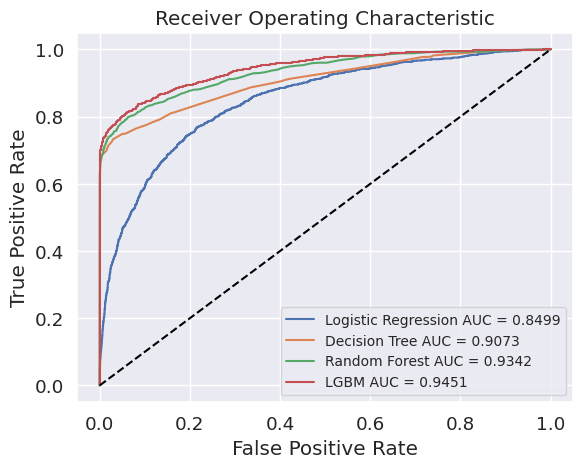

In [ ]:
# Get predicted probabilities for the positive class from each model
log_gs_prob = best_model_logistic.predict_proba(X_test3)[:,1]
dt_tune_prob = DecisionTree_tune.predict_proba(X_test2)[:,1]
rf_gs_prob = best_model_rf.predict_proba(X_test2)[:,1]
lgbm_gs_prob = best_model_lgbm.predict_proba(X_test2.drop(columns=['cb_person_default_on_file']))[:,1]
#XGB_gs_prob = best_model_XGB.predict_proba(X_test2)[:,1]
#KNN_gs_prob = best_model_KNN.predict_proba(X_test1)[:,1]

# Get the fpr, tpr, thresholds for each model
log_fpr, log_tpr, log_thresholds = metrics.roc_curve(y_test3, log_gs_prob)
dt_fpr, dt_tpr, dt_thresholds = metrics.roc_curve(y_test2, dt_tune_prob)
rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve(y_test2, rf_gs_prob)
lgbm_fpr, lgbm_tpr, lgbm_thresholds = metrics.roc_curve(y_test2, lgbm_gs_prob)
#XGB_fpr, XGB_tpr, XGB_thresholds = metrics.roc_curve(y_test2, XGB_gs_prob)
#KNN_fpr, KNN_tpr, KNN_thresholds = metrics.roc_curve(y_test1, KNN_gs_prob)
fpr = [log_fpr, dt_fpr, rf_fpr, lgbm_fpr] #XGB_fpr, KNN_fpr
tpr = [log_tpr, dt_tpr, rf_tpr, lgbm_tpr] #XGB_tpr, KNN_tpr

# Calulate the AUC
log_auc = metrics.roc_auc_score(y_test3, log_gs_prob)
dt_auc = metrics.roc_auc_score(y_test2, dt_tune_prob)
rf_auc = metrics.roc_auc_score(y_test2, rf_gs_prob)
lgbm_auc = metrics.roc_auc_score(y_test2, lgbm_gs_prob)
#XGB_auc = metrics.roc_auc_score(y_test2, XGB_gs_prob)
#KNN_auc = metrics.roc_auc_score(y_test1, KNN_gs_prob)
auc = [log_auc, dt_auc, rf_auc, lgbm_auc] #XGB_auc, KNN_auc

#create ROC curve
model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "LGBM"] #"XGBoost", "KNN"

plt.figure()
for i in range(len(fpr)):
    plt.plot(fpr[i], tpr[i], label=model_names[i] + " AUC = {:.4f}".format(auc[i]))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right', prop={'size': 10})
plt.show()

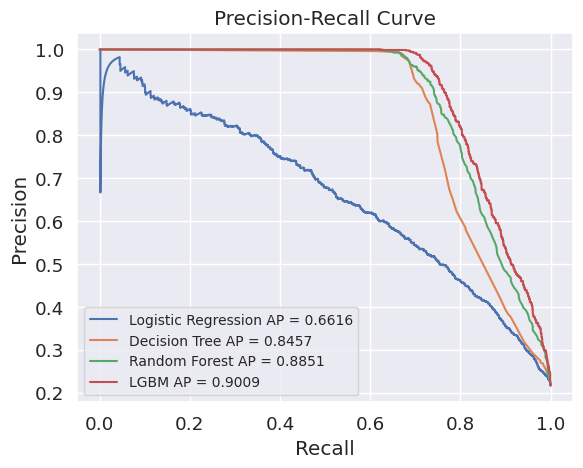

In [ ]:
# Get the precision, recall, thresholds for each model
log_precision, log_recall, log_thresholds = metrics.precision_recall_curve(y_test1, log_gs_prob)
dt_precision, dt_recall, dt_thresholds = metrics.precision_recall_curve(y_test2, dt_tune_prob)
rf_precision, rf_recall, rf_thresholds = metrics.precision_recall_curve(y_test2, rf_gs_prob)
lgbm_precision, lgbm_recall, lgbm_thresholds = metrics.precision_recall_curve(y_test2, lgbm_gs_prob)
#XGB_precision, XGB_recall, XGB_thresholds = metrics.precision_recall_curve(y_test2, XGB_gs_prob)
#KNN_precision, KNN_recall, KNN_thresholds = metrics.precision_recall_curve(y_test1, KNN_gs_prob)
precision = [log_precision, dt_precision, rf_precision, lgbm_precision] #XGB_precision, KNN_precision
recall = [log_recall, dt_recall, rf_recall, lgbm_recall] #XGB_recall, KNN_recall

# Calulate the average precision score
log_avg_precision = metrics.average_precision_score(y_test1, log_gs_prob)
dt_avg_precision = metrics.average_precision_score(y_test2, dt_tune_prob)
rf_avg_precision = metrics.average_precision_score(y_test2, rf_gs_prob)
lgbm_avg_precision = metrics.average_precision_score(y_test2, lgbm_gs_prob)
#XGB_avg_precision = metrics.average_precision_score(y_test2, XGB_gs_prob)
#KNN_avg_precision = metrics.average_precision_score(y_test1, KNN_gs_prob)
avg_precision = [log_avg_precision, dt_avg_precision, rf_avg_precision, lgbm_avg_precision] #XGB_avg_precision, KNN_avg_precision

# Create PR curve
model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "LGBM"] #"XGBoost", "KNN"

plt.figure()
for i in range(len(precision)):
    plt.plot(recall[i], precision[i], label=model_names[i] + " AP = {:.4f}".format(avg_precision[i]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left', prop={'size': 10})
plt.show()